In [49]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import models, layers
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, MultiHeadAttention, LayerNormalization, Dropout
import yfinance as yf
import datetime
from sklearn.preprocessing import StandardScaler

end_date = datetime.datetime.now() 
start_date = end_date - datetime.timedelta(days = 365 * 5) # we are using 5 years of historical data
data = yf.download('TSLA', start=start_date.date(), end=end_date.date())

# Fetch historical data for TSLA
# data = yf.download('TSLA', start='2020-01-01', end='2023-01-01')

# Use High, Low, Open, Close features
features = data[['High', 'Low', 'Open', 'Close']].values

SEQLEN = 5

[*********************100%%**********************]  1 of 1 completed


In [50]:
# Function to create dataset for multi-feature input
def create_dataset(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : (i + sequence_length) ])
        y.append(data[i + sequence_length, 3]) # Target is the Close price
    return np.array(X), np.array(y)

X, y = create_dataset(features, SEQLEN)

# Split dataset into training and testing
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit on training data only
# Since X_train is 3D (samples, SEQLEN, features) and StandardScaler works on 2D,
# you need to reshape X_train to 2D, scale it, then reshape it back to 3D.
num_instances, num_steps, num_features = X_train.shape
X_train_reshaped = X_train.reshape(-1, num_features)  # Reshape to 2D
scaler.fit(X_train_reshaped)  # Fit scaler to training data

# Transform training data
X_train_scaled = scaler.transform(X_train_reshaped).reshape(num_instances, num_steps, num_features)

# Transform testing data (also reshape, transform, and reshape back)
num_instances_test, _, _ = X_test.shape
X_test_scaled = scaler.transform(X_test.reshape(-1, num_features)).reshape(num_instances_test, num_steps, num_features)

scaler_target = StandardScaler()

# Reshape y_train to 2D if it's originally 1D, for compatibility with the scaler
y_train_reshaped = y_train.reshape(-1, 1)

# Fit the scaler on the training target data
scaler_target.fit(y_train_reshaped)

# Transform the training target data
y_train_scaled = scaler_target.transform(y_train_reshaped)

# Transform the testing target data (ensure to reshape y_test if it's 1D)
y_test_scaled = scaler_target.transform(y_test.reshape(-1, 1))



In [51]:
class SinusoidalPositionalEncoding(tf.keras.layers.Layer): 
    def __init__(self, sequence_size, embedding_dim, **kwargs):
        super().__init__(**kwargs)
        self.pos_encoding = self.positional_encoding(sequence_size, embedding_dim)
    
    def get_angles(self, position, i, embedding_dim):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(embedding_dim, tf.float32))
        return position * angles
    
    def positional_encoding(self, sequence_size, embedding_dim):
        angle_rads = self.get_angles(position=tf.range(sequence_size, dtype=tf.float32)[:, tf.newaxis],
                                     i=tf.range(embedding_dim, dtype=tf.float32)[tf.newaxis, :],
                                     embedding_dim=embedding_dim)
        # Apply sin to even indices in the array; 2i
        sines = tf.math.sin(angle_rads[:, 0::2])
        # Apply cos to odd indices in the array; 2i+1
        cosines = tf.math.cos(angle_rads[:, 1::2])
        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)
    
    def call(self, inputs):
        return inputs + self.pos_encoding[: , :tf.shape(inputs)[1], :]


Epoch 1/200
25/25 [==============================] - 2s 10ms/step - loss: 0.5719 - mean_squared_error: 0.5719 - mean_absolute_error: 0.6157 - mean_absolute_percentage_error: 63.2961 - val_loss: 0.0459 - val_mean_squared_error: 0.0459 - val_mean_absolute_error: 0.1766 - val_mean_absolute_percentage_error: 86.7292
Epoch 2/200
25/25 [==============================] - 0s 2ms/step - loss: 0.1460 - mean_squared_error: 0.1460 - mean_absolute_error: 0.3018 - mean_absolute_percentage_error: 53.6483 - val_loss: 0.0760 - val_mean_squared_error: 0.0760 - val_mean_absolute_error: 0.2197 - val_mean_absolute_percentage_error: 102.4629
Epoch 3/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0840 - mean_squared_error: 0.0840 - mean_absolute_error: 0.2169 - mean_absolute_percentage_error: 34.3180 - val_loss: 0.0342 - val_mean_squared_error: 0.0342 - val_mean_absolute_error: 0.1474 - val_mean_absolute_percentage_error: 82.8622
Epoch 4/200
25/25 [==============================] - 0s 2ms

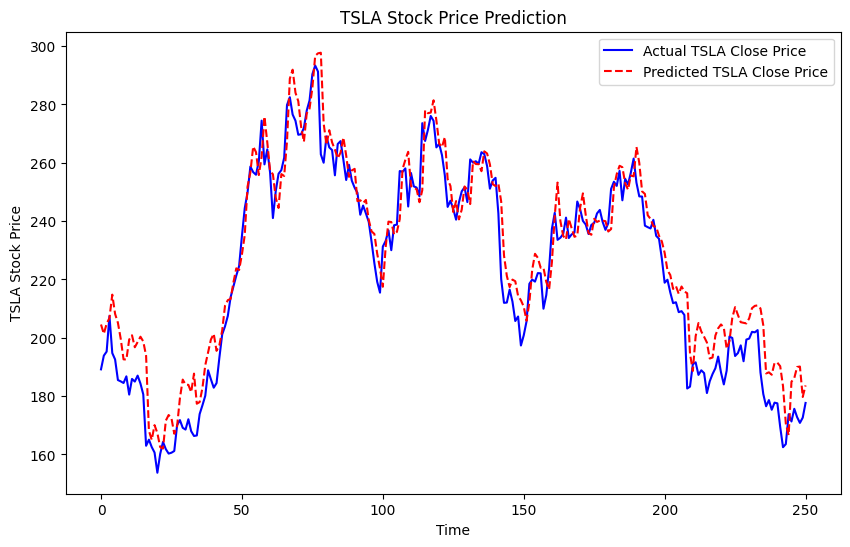

In [52]:
# Define the transformer model
def Transformer(sequence_size, feature_size=4, num_heads=2, ff_dim=64, dropout=0.1, num_transformer_blocks=2):
    inputs = layers.Input(shape=(sequence_size, feature_size))
    x = SinusoidalPositionalEncoding(sequence_size, feature_size)(inputs)
    
    for _ in range(num_transformer_blocks):  # multiple Transformer blocks
        attn = layers.MultiHeadAttention(key_dim=feature_size, num_heads=num_heads)(x, x)
        attn = layers.Dropout(dropout)(attn)
        norm = layers.LayerNormalization(epsilon=1e-6)(x + attn)  # Add & Norm
        ffn = layers.Dense(ff_dim, activation="relu")(norm)
        ffn = layers.Dropout(dropout)(ffn)
        ffn = layers.Dense(feature_size)(ffn)
        x = layers.LayerNormalization(epsilon=1e-6)(norm + ffn)  # Add & Norm
    
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1)(x)
    model = models.Model(inputs=inputs, outputs=outputs)

    return model

model = Transformer(SEQLEN, feature_size=4, num_heads=2, ff_dim=64, num_transformer_blocks=3)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error'])

# Train the model
# history = model.fit(X_train_scaled, y_train, batch_size=32, epochs=100, validation_split=0.2, verbose=1)

early_stopping = EarlyStopping(monitor='val_loss',min_delta=0, patience=100, verbose=1, mode='auto', restore_best_weights=True)

history = model.fit(X_train_scaled, y_train_scaled, batch_size=32, epochs=200, callbacks=[early_stopping], validation_split=0.2, verbose=1)

# Evaluate the model on the test set
test_metrics = model.evaluate(X_test_scaled, y_test_scaled)
print(f'Test Metrics (Loss, MSE, MAE, MAPE): {test_metrics}')

# Predict and inverse-transform the normalization for the Close price
predictions = model.predict(X_test_scaled)
predictions = scaler_target.inverse_transform(predictions)

# predictions = predictions * std[-1] + mean[-1] # Inverse transformation for the Close price
# predictions = scaler.inverse_transform(predictions.reshape(-1,1))

import matplotlib.pyplot as plt

# actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual TSLA Close Price', color='blue')
plt.plot(predictions, label='Predicted TSLA Close Price', color='red', linestyle='--')
plt.title('TSLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TSLA Stock Price')
plt.legend()
plt.show()